In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt
import tensorflow_probability as tfp
import sympy

# Gaussian Processes

Text(0.5, 0, 'x')

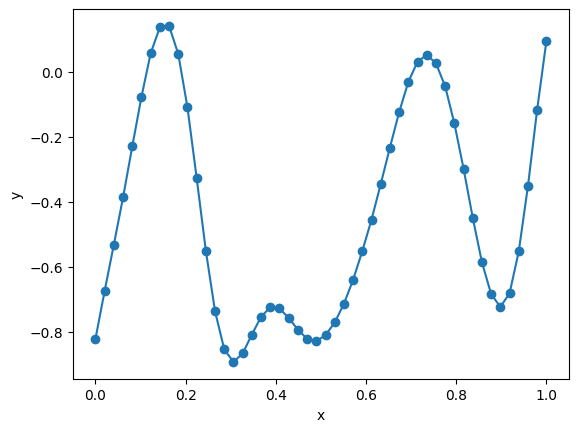

In [10]:
#MvN for function evaluations
x = np.linspace(0,1,50)

sig = np.exp(-50*(x[:,None]-x[None])**2)
L = np.linalg.cholesky(sig+1e-6*np.eye(len(x)))
z = np.random.normal(0,1,len(x))
L.dot(z)

plt.plot(x,L.dot(z),'-o')
plt.ylabel('y')
plt.xlabel('x')

Text(0.5, 0, 'x')

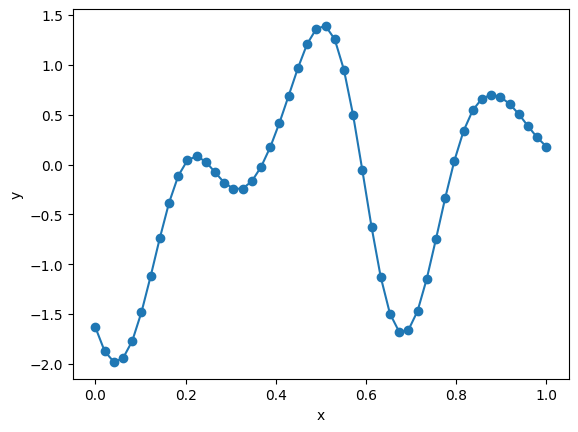

In [13]:
#Define a function for the covariance
def K(x1,x2):
    return np.exp(-50.*(x1[:,None]-x2[None])**2)
Kxx = K(x,x)
L = np.linalg.cholesky(Kxx+1e-6*np.eye(len(x)))
z = np.random.normal(0,1,len(x))
L.dot(z)

plt.plot(x,L.dot(z),'-o')
plt.ylabel('y')
plt.xlabel('x')

# Gaussian process regression

In [ ]:
#Plot data and true function
x_all = np.linspace(0,1,100)
y_true = x_all**2+.5*x_all-.5

x_data = np.random.uniform(.2,.8,5)
y_data = (x_data**2+.5*x_data-.5) + np.random.normal(0,.05,len(x_data))


def plot_data():
    plt.plot(x_all,y_true,label='True function')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.plot(x_data,y_data,'ro',label='Data points')


plot_data()
plt.legend()


In [ ]:
#kernels
K11 = K(x_all,x_all)+1e-4*np.eye(len(x_all))
K12 = K(x_all,x_data)
K22 = K(x_data,x_data)+1e-4*np.eye(len(x_data))

In [ ]:
#Prior
sig_prior = np.sqrt(np.diag(K11))
plt.plot(x_all,0.*x_all,color='C1',label='Prior predictive mean')
plt.fill_between(x_all,-2*sig_prior,2*sig_prior,color='C4',label='95% confidence')


In [ ]:

mu = K12.dot(np.linalg.solve(K22,y_data))
K1_2 = K11 - K12.dot(np.linalg.inv(K22)).dot(K12.T)
chol = np.linalg.cholesky(K1_2)
sig = np.sqrt(np.diag(K1_2))

plot_data()
plt.plot(x_all,mu,label='Posterior predictive mean')
plt.fill_between(x_all,mu-2*sig,mu+2*sig,color='C4',label='95% confidence')
plt.legend()

# Constraints

In [ ]:
#Plot data and true function. Conditioned on y(x=0)=1
x_all = np.linspace(0,1,100)
y_true = x_all**2+.5*x_all-.5

x_data = np.random.uniform(.2,.6,50)
y_data = (x_data**2+.5*x_data-.5)
x_data = np.concatenate([[0,1],x_data])
y_data = np.concatenate([[1],y_data])
y_data = np.concatenate([[1],y_data])
plot_data()
plt.legend()


In [ ]:
#kernels
K11 = K(x_all,x_all)+1e-4*np.eye(len(x_all))
K12 = K(x_all,x_data)
K22 = K(x_data,x_data)+1e-4*np.eye(len(x_data))



#Gaussian process regression

mu = K12.dot(np.linalg.solve(K22,y_data))
K1_2 = K11 - K12.dot(np.linalg.inv(K22)).dot(K12.T)
chol = np.linalg.cholesky(K1_2)
sig = np.sqrt(np.diag(K1_2))

plot_data()
plt.plot(x_all,mu,label='Posterior predictive mean')
plt.fill_between(x_all,mu-2*sig,mu+2*sig,color='C4',label='95% confidence')
plt.legend()

In [ ]:
x,xp,a,l = sympy.symbols('x xp a l')


K    = a*sympy.exp(-l*(x-xp)**2*1)
Kx   = sympy.diff(K,x)
Kxp  = sympy.diff(K,xp)
Kxxp = sympy.diff(Kx,xp)

fK = sympy.lambdify([x,xp,a,l],K,modules='tensorflow')
fKx = sympy.lambdify([x,xp,a,l],Kx,modules='tensorflow')
fKxp = sympy.lambdify([x,xp,a,l],Kxp,modules='tensorflow')
fKxxp = sympy.lambdify([x,xp,a,l],Kxxp,modules='tensorflow')


In [ ]:
K11 = fK(x_all[:,None],x_all[None],1.,1.)
K12 = fKxp(x_all[:,None],x_all[None],1.,1.)
K22 = fKxxp(x_all[:,None],x_all[None],np.float64(1.),np.float64(1.))

K = np.block([[K11,K12],[tf.transpose(K12),K22]])

chol = np.linalg.cholesky(K+1e-8*np.eye(K.shape[0]))
z= np.random.normal(0,1,chol.shape[0])
f_df = chol.dot(z)
f = f_df[0:len(x_all)]
df = f_df[len(x_all):]
plt.plot(x_all,f,label='GP function')
plt.plot(x_all,df,label='GP derivative')
plt.plot(.5*(x_all[0:-1]+x_all[1:]),(f[1:]-f[0:-1])/(x_all[1]-x_all[0]),'--',label='finite difference')
plt.legend()

# Type II Likelihood optimization

In [ ]:
#Plot data and true function
x_all = np.linspace(0,1,100)
y_true = x_all**2+.5*x_all-.5
x_data = np.random.uniform(.2,.8,5)
y_data = (x_data**2+.5*x_data-.5) + np.random.normal(0,.05,len(x_data))

def plot_data():
    plt.plot(x_all,y_true,label='True function')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.plot(x_data,y_data,'ro',label='Data points')

plot_data()
plt.legend()


In [ ]:
x,xp,a,l = sympy.symbols('x xp a l')


K    = a*sympy.exp(-l*(x-xp)**2*1)

fK = sympy.lambdify([x,xp,a,l],K,modules='tensorflow')

#kernels
a=100.
l=1000
K11 = fK(x_all[:,None],x_all[None],a,l)+1e-4*np.eye(len(x_all))
K12 = fK(x_all[:,None],x_data[None],a,l)
K22 = fK(x_data[:,None],x_data[None],a,l)+1e-4*np.eye(len(x_data))

#Gaussian process regression
mu = tf.linalg.matvec(K12,(tf.linalg.solve(K22,y_data[:,None])[:,0]))
K1_2 = K11 - tf.einsum('ij,jk,lk',K12,tf.linalg.inv(K22),K12)

chol = tf.linalg.cholesky(K1_2)
sig = np.sqrt(np.diag(K1_2))

plot_data()
plt.plot(x_all,mu,label='Posterior predictive mean')
plt.fill_between(x_all,mu-2*sig,mu+2*sig,color='C4',label='95% confidence')
plt.legend()


In [ ]:

with tf.device('/CPU:0'):

    a = tf.Variable(a,dtype=tf.float64)
    l = tf.Variable(l,dtype=tf.float64)

    def loss(p):
        a=tf.nn.relu(p[0])+1e-5
        l=tf.nn.relu(p[1])+1e-5
        K22 = fK(x_data[:,None],x_data[None],a,l)+1e-4*np.eye(len(x_data))
        return tf.einsum('i,ij,j',y_data,tf.linalg.inv(K22),y_data) + tf.linalg.logdet(K22)

    opt = tf.keras.optimizers.legacy.Adam(1e-3)
    @tf.function
    def GD():
        with tf.GradientTape() as tape:
            p = [a,l]
            tape.watch(p)
            loss_ = loss(p)
        grad = tape.gradient(loss_,p)
        opt.apply_gradients(zip(grad,p))
        return loss_
    
    def loss_grad(p):
        return tfp.math.value_and_gradient(loss,p)
    @tf.function
    def grad(p):
        return tf.gradients(loss(p),p)
    

    for _ in range(1000):
        print(GD().numpy())

In [ ]:
optim_results = tfp.optimizer.bfgs_minimize(
      loss_grad,
      initial_position=[a,l],
      tolerance=1e-6)
print(optim_results.converged,optim_results.position,[a,l])
a_s,l_s = optim_results.position


In [ ]:
#kernels
K11 = fK(x_all[:,None],x_all[None],a_s,l_s)+1e-4*np.eye(len(x_all))
K12 = fK(x_all[:,None],x_data[None],a_s,l_s)
K22 = fK(x_data[:,None],x_data[None],a_s,l_s)+1e-4*np.eye(len(x_data))

#Gaussian process regression
mu = tf.linalg.matvec(K12,(tf.linalg.solve(K22,y_data[:,None])[:,0]))
K1_2 = K11 - tf.einsum('ij,jk,lk',K12,tf.linalg.inv(K22),K12)

chol = tf.linalg.cholesky(K1_2)
sig = np.sqrt(np.diag(K1_2))

plot_data()
plt.plot(x_all,mu,label='Posterior predictive mean')
plt.fill_between(x_all,mu-2*sig,mu+2*sig,color='C4',label='95% confidence')
plt.legend()